# Team 6 CT Classification

## Climate Change Sentiment analysis - 2020

### Project Description


>Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

>With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

>Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

![alt text](https://images.unsplash.com/photo-1578825141469-690ba22eede0?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1051&q=80)

### Notebook Explanation

First, we tried 3 base models with no preprocessing of the text to get a benchmark score. We then extracted info from the tweets and added additional columns such as character and words count.

The next step was cleaning the tweets. For example, we removed the URLs, the <i>'RT'</i> retweet tags and the mentions. We applied both stemming and lemmatisation normalising methods to test which performs better. Following that, we vectorized the text using 3 methods: Count Vectoriser, TD-IDF and Word2Vec. We added additional columns for each of the combinations of methods and ran each combination through the base models again and compared the performance. This was an iterative process until we got the best performing cleaning method.

After deciding on the best cleaning method, we did an Exploratory data analysis (EDA) on the raw tweets to retrieve data about mentions and hashtags. We also did EDA on the categorised processed tweets to extract insights from most the different sentiment labels.

Next, we compared base models with the processed tweets. We selected the top 3 performing models and used GridSearchCV to find the best parameters to train these models with. We compared the F1 score and selected the best performing model. Below is a model process flow diagram visualising the approach we took to solve this problem.

<img src="resources/Model Process Flow.png" />

<a id = "top"></a>

# Table of contents

1. [Importing packages](#packages) <br><br>

2. [Loading and viewing data](#data) <br><br>

3. [Data Description](#description) <br><br>

4. [Sentiment Description](#sentiment)<br><br>

5. [Data Extraction](#extraction)<br><br>

6. [Text cleaning](#cleaning) <br><br>

7. [Exploratory data analysis](#eda)<br><br>

8. [Modeling](#modeling) <br><br>

9. [Model performance](#performance) <br><br>

10. [Hyperparameter optimisation](#optimisation) <br><br>

11. [Conlusion](#conclusion) <br><br>

# 1. Importing packages <a name="packages"></a>
[Return to top](#top) <br><br>

The following packages need to be installed.

- Spacy - pip install spacy==2.2.4
- NTLK - pip indstal nltk==3.5

In [1]:
# Processing
import numpy as np
import pandas as pd
import re

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Spacy packages
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS

# NLTK packages
import nltk
from nltk.tokenize import word_tokenize,TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt', quiet=True)

# Sklearn packages
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# Utils
from collections import Counter
import itertools, string, operator, re, unicodedata, nltk

C:\Users\Jonathan\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
print('Spacy version: ',spacy.__version__)
print('NTLK version: ', nltk.__version__)

Spacy version:  2.3.0
NTLK version:  3.4.4


# 2. Loading  and Copy Data <a name="data"></a>
[Return to top](#top) <br><br>


- Data loads from Github repository
- Training dataset has 15799 entries
- Testing dataset has 10546 entries
- Viewing the first 5 rows of datasets


In [3]:
# Import data
train_df = pd.read_csv('https://raw.githubusercontent.com/jonnybegreat/test-repo/master/twitter_train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/jonnybegreat/test-repo/master/twitter_test.csv')

In [4]:
# Make copy of train_df assigning to variable df and view the first 5 rows
df = train_df.copy()
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
# View the first 5 rows of test dataset
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# 3. Data Description <a name="description"></a>
[Return to top](#top) <br><br>

<b>Training data columns (15799 entries):</b>
- Sentiment - Labelled sentiment classification
- Message - Tweet to analysed
- Tweet ID - ID of unique tweet

<b>Test data columns (10546 entries):</b>
- Message - Tweet to be analysed
- Tweet ID - ID of unique tweet


<i>Training data info and data types:</i>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


<i>Testing data info and data types:</i>

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


# 4. Sentiment Description <a name="sentiment"></a>
[Return to top](#top) <br><br>

The table displays the description of each sentiment category:

![alt text](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2205222%2F8e4d65f2029797e0462b52022451829c%2Fdata.PNG?generation=1590752860255531&alt=media)

<i>How many tweets are there in each category?</i>

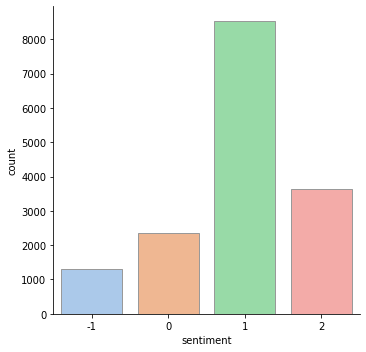

In [8]:
#Bar graph of sentiment count
sns.catplot(x="sentiment", kind="count", edgecolor=".6",palette="pastel",data=df);

Majority of the tweets are positive(1) towards climate change. The least amount of tweets are negative (-1) towards climate change. This shows data is unbalanced and can affect our prediction results. Later in this notebook, we will explore resampling methods to balance the data.

# 5. Data Extraction <a name="extraction"></a>
[Return to top](#top) <br><br>


Create new columns of the following features of the tweets:
- Tokenise tweet
- Categorise as retweet or not
- Hashtag extraction and count
- Mention extraction and count
- Word and character count
- Average word length
- Stop word count per


In [9]:
# Create copies
df_with_metadata = df.copy()
test_df_with_metadata = test_df.copy()

In [10]:
# Hashtags function - NEEDS TO BE EDITED TO INCLUDE MULTIPLE HASHTAGS
def hashtag_column(x):

    hashtags = []
    new_tag_list = []

    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)         

    for tag in hashtags:
        if tag == []:
            tag = np.nan
        new_tag_list.append(tag)
        
    return new_tag_list

In [11]:
# Mentions function - NEEDS TO BE EDITED TO INCLUDE MULTIPLE MENTIONS
def mention_column(x):

    mentions = []
    new_mention_list = []

    for i in x:
        ht = re.findall(r"@(\w+)", i)
        mentions.append(ht)         

    for tag in mentions:
        if tag == []:
            tag = np.nan
        new_mention_list.append(tag)
        
    return new_mention_list

In [12]:
# Tokenized tweet
df_with_metadata['message_token'] = df_with_metadata['message'].apply(lambda x: word_tokenize(x))


In [13]:
# Categorise as retweet or not
df_with_metadata['retweet'] = ['yes' if df_with_metadata['message'][i][:2] == 'RT' else 'no' for i in range(len(df_with_metadata))]


In [14]:
# Hashtag extraction and count
df_with_metadata['hashtags'] = hashtag_column(df_with_metadata['message'])
test_df_with_metadata['hashtags'] = hashtag_column(test_df_with_metadata['message'])
df_with_metadata['hashtag_count'] = df_with_metadata['message'].apply(lambda tweet: len([word for word in tweet.split() if word.startswith('#')]))
test_df_with_metadata['hashtag_count'] = test_df_with_metadata['message'].apply(lambda tweet: len([word for word in tweet.split() if word.startswith('#')]))


In [15]:
# Mention extraction and count
df_with_metadata['mentions'] = mention_column(df_with_metadata['message'])
test_df_with_metadata['mentions'] = mention_column(test_df_with_metadata['message'])
df_with_metadata['mention_count'] = df_with_metadata['message'].apply(lambda tweet: len([word for word in tweet.split() if word.startswith('@')]))
test_df_with_metadata['mention_count'] = test_df_with_metadata['message'].apply(lambda tweet: len([word for word in tweet.split() if word.startswith('@')]))


In [16]:
# Character and word count
df_with_metadata['char_count'] = df_with_metadata['message'].str.len()
test_df_with_metadata['char_count'] = test_df_with_metadata['message'].str.len()
df_with_metadata['word_count'] = df_with_metadata['message'].str.split().str.len()
test_df_with_metadata['word_count'] = test_df_with_metadata['message'].str.split().str.len()


In [17]:
# Average word length
df_with_metadata['avg_word_length'] = df_with_metadata['message'].apply(lambda tweet: round(sum([len(word) for word in tweet.split()]) / len(tweet.split()),2))
test_df_with_metadata['avg_word_length'] = test_df_with_metadata['message'].apply(lambda tweet: round(sum([len(word) for word in tweet.split()]) / len(tweet.split()),2))

In [18]:
# Stop word count
df_with_metadata['stopword_count'] = df_with_metadata['message'].apply(lambda tweet: len([word for word in tweet.split() if word in STOP_WORDS]))
test_df_with_metadata['stopword_count'] = test_df_with_metadata['message'].apply(lambda tweet: len([word for word in tweet.split() if word in STOP_WORDS]))

# 6. Text Cleaning <a name="cleaning"></a>
[Return to top](#top) <br><br>


The following text cleaning processes were applied to the tweets:
- Upon inspection there is a common recurrence of the following special character combination: 'Ã¢â‚¬Â¦'
- Tokenise text
- Make the text lowercase
- Expand contracted words
- Part of speech tagging
- Lemmatising text - replace with base words
- Remove numbers
- Remove punctuation
- Remove stop words 

Stop words are commonly used words such as 'the', 'a' and 'in'.

In [19]:
#Contraction dictionary
c_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))


In [20]:
# Creating library objects
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
punc = list(set(string.punctuation))

# Adding additional stop words
additional_stopwords = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\']
stop_words = ENGLISH_STOP_WORDS.union(additional_stopwords)

# Function to expand contracted words
def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

# Function to extract parts of speech
def get_word_net_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
# Function to lemmamtise words
def lemma_wordnet(tagged_text):
    final = []
    for word, tag in tagged_text:
        wordnet_tag = get_word_net_pos(tag)
        if wordnet_tag is None:
            final.append(lemmatizer.lemmatize(word))
        else:
            final.append(lemmatizer.lemmatize(word, pos=wordnet_tag))
    return final

def process_text(text):
    '''
    Function to tokenise text, make all the text lowercase, 
    expanding contracted words, extracting parts of speech tags,
    lemmatising text, and removing numbers, punctuation and stop words.
    '''
    tokenized = tokenizer.tokenize(text)
    lower = [item.lower() for item in tokenized]
    decontract = [expandContractions(item, c_re=c_re) for item in lower]
    tagged = nltk.pos_tag(decontract)
    lemma = lemma_wordnet(tagged)
    no_num = [re.sub('[0-9]+', '', each) for each in lemma]
    no_punc = [w for w in no_num if w not in punc]
    no_stop = [w for w in no_punc if w not in stop_words]
    return no_stop

# Clean the tweets on training and testing data
df_with_metadata['cleaned_text'] = df_with_metadata['message'].apply(process_text)
test_df_with_metadata['cleaned_text'] = test_df_with_metadata['message'].apply(process_text)

Let's look at the sentiment and cleaned tweet tokens in comparison with the original tweets.

In [21]:
# Display cleaned tweets
df_with_metadata[['message','cleaned_text','sentiment']]

,message,cleaned_text,sentiment
0,PolySciMajor EPA chief doesn't think carbon di...,"[polyscimajor, epa, chief, does not, think, ca...",1
1,It's not like we lack evidence of anthropogeni...,"[it is, like, lack, evidence, anthropogenic, g...",1
2,RT @RawStory: Researchers say we have three ye...,"[rt, @rawstory, researcher, year, act, climate...",2
3,#TodayinMaker# WIRED : 2016 was a pivotal year...,"[#todayinmaker, wire, pivotal, year, war, clim...",1
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...","[rt, @soynoviodetodas, it is, racist, sexist, ...",1
...,...,...,...
15814,RT @ezlusztig: They took down the material on ...,"[rt, @ezlusztig, material, global, warming, lg...",1
15815,RT @washingtonpost: How climate change could b...,"[rt, @washingtonpost, climate, change, break, ...",2
15816,notiven: RT: nytimesworld :What does Trump act...,"[notiven, rt, nytimesworld, trump, actually, b...",0
15817,RT @sara8smiles: Hey liberals the climate chan...,"[rt, @sarasmiles, hey, liberals, climate, chan...",-1


# 7. Exploratory Data Analysis <a name="eda"></a>
[Return to top](#top) <br><br>


We will be exploring our data and drawing information from the original tweets, the cleaned tweets and the data we have extracted.

Let's take another look at the columns that were created.

In [22]:
df_with_metadata.head()

,sentiment,message,tweetid,message_token,retweet,hashtags,hashtag_count,mentions,mention_count,char_count,word_count,avg_word_length,stopword_count,cleaned_text
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,"[PolySciMajor, EPA, chief, does, n't, think, c...",no,NaN,0,[mashable],1,140,19,6.42,3,"[polyscimajor, epa, chief, does not, think, ca..."
1,1,It's not like we lack evidence of anthropogeni...,126103,"[It, 's, not, like, we, lack, evidence, of, an...",no,NaN,0,NaN,0,62,10,5.30,3,"[it is, like, lack, evidence, anthropogenic, g..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,"[RT, @, RawStory, :, Researchers, say, we, hav...",yes,NaN,0,[RawStory],1,140,19,6.42,8,"[rt, @rawstory, researcher, year, act, climate..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,"[#, TodayinMaker, #, WIRED, :, 2016, was, a, p...",no,[TodayinMaker],1,NaN,0,99,15,5.67,5,"[#todayinmaker, wire, pivotal, year, war, clim..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"[RT, @, SoyNovioDeTodas, :, It, 's, 2016, ,, a...",yes,[ElectionNight],1,[SoyNovioDeTodas],1,122,18,5.83,5,"[rt, @soynoviodetodas, it is, racist, sexist, ..."


### Retweets
Let's start by looking at the retweets. 

Yes:  60.94 %
No:  39.06 %


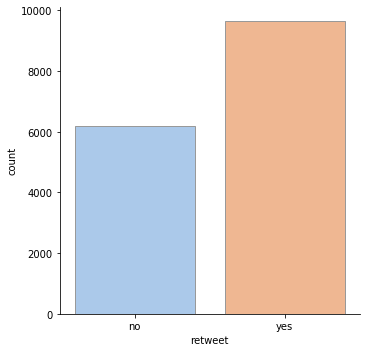

In [23]:
#Bar graph of number of rewteets
sns.catplot(x="retweet", kind="count", edgecolor=".6",palette="pastel",
            data=df_with_metadata);
valuecounts = df_with_metadata['retweet'].value_counts()
print('Yes: ', round(valuecounts[0]/len(df_with_metadata['retweet'])*100,2),'%')
print('No: ', round(valuecounts[1]/len(df_with_metadata['retweet'])*100,2),'%')

Just over 60% of these tweets are Retweets! There might be some duplicate tweets. We explore by taking a look at the top 10 most retweeted tweets and how many times they were retweeted.

In [36]:
#View the top 10 retweeted tweets
df_rt_counts = pd.DataFrame(df_with_metadata['message'].astype(str).value_counts())
df_rt_counts.head(10)

,message
RT @StephenSchlegel: she's thinking about how she's going to die because your husband doesn't believe in climate change https://t.co/SjoFoNÃ¢â‚¬Â¦,307
RT @SenSanders: We have a president-elect who doesn't believe in climate change. Millions of people are going to have to say: Mr. TÃ¢â‚¬Â¦,130
"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",73
RT @BernieSanders: #ImVotingBecause the future of the planet is at stake. Hillary Clinton will combat climate change. Donald Trump thinks iÃ¢â‚¬Â¦,59
RT @SethMacFarlane: HRC proposes installing half a billion solar panels by the end of her first term. Trump thinks climate change is a hoaxÃ¢â‚¬Â¦,56
RT @BernieSanders: 'The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitiÃ¢â‚¬Â¦,44
RT @SenSanders: We have a president-elect who doesnÃ¢â‚¬â„¢t believe in climate change. ThatÃ¢â‚¬â„¢s frightening for this country and the world.,35
RT @CNN: No snow where there should be. Bleached anemones. Cracks in the ice. This is what climate change looks like:Ã¢â‚¬Â¦,33
"RT @ddlovato: #IVotedBecause I believe in equality, we need comprehensive immigration reform, I am pro-choice and global warming IS real. #Ã¢â‚¬Â¦",32
RT @SenSanders: If we don't address climate change there'll be more conflict over limited resources. We must listen to scientists not fossiÃ¢â‚¬Â¦,24


We have alot of the same tweet occurences so we would assume that the sentiment would be the same for each of them. Let's look at the top duplicate tweet to confirm this.

In [25]:
#View sentiment of tweet with the highest retweet count
df_most_duplicated_tweet = pd.DataFrame(df_with_metadata[df_with_metadata['message'] == "RT @StephenSchlegel: she's thinking about how she's going to die because your husband doesn't believe in climate change https://t.co/SjoFoNÃ¢â‚¬Â¦"])
df_most_duplicated_tweet[['message','sentiment']]


,message,sentiment
10,RT @StephenSchlegel: she's thinking about how ...,1
51,RT @StephenSchlegel: she's thinking about how ...,1
98,RT @StephenSchlegel: she's thinking about how ...,1
122,RT @StephenSchlegel: she's thinking about how ...,1
142,RT @StephenSchlegel: she's thinking about how ...,1
...,...,...
15652,RT @StephenSchlegel: she's thinking about how ...,1
15707,RT @StephenSchlegel: she's thinking about how ...,1
15716,RT @StephenSchlegel: she's thinking about how ...,1
15781,RT @StephenSchlegel: she's thinking about how ...,1


There are quite a couple of duplicate tweets with the same sentiment. This might be a problem and lead to over importance of certain categories.
 
There is also a recurrence of the following special character combination: 'Ã¢â‚¬Â¦'.


### Hashtags and Mentions

We can tell a lot from the sentiment of tweets by looking at the hashtags which are used. Which hashtags appear the most in these tweets?

In [26]:
# def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
#     h = int(360.0 * 21.0 / 255.0)
#     s = int(100.0 * 255.0 / 255.0)
#     l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    
#     return "hsl({}, {}%, {}%)".format(h, s, l)

## Add color_func=random_color_func as argumnt to wordcloud generator

Word cloud of top hashtags


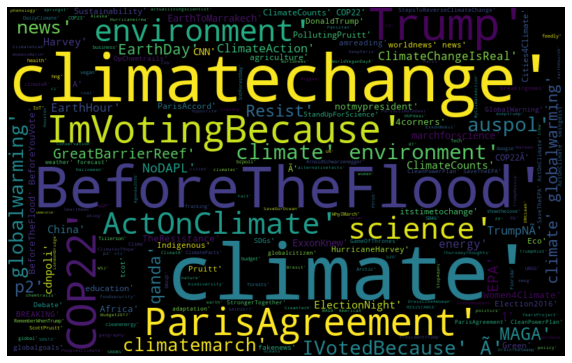

In [27]:
df_hashtags = df_with_metadata['hashtags'].dropna()

all_words_hastags = ' '.join([text for text in df_hashtags.astype(str)])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_hastags)

print('Word cloud of top hashtags')
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Looking at popular hashtags across all categories its seems as though the prominent hashtags include: 'Climatechange','climate','ActOnClimate'
These are to be expected as this dataset are tweets related to climate change.

Other prominent hashtags include: 'Paris Agreement', 'Trump','MAGA' etc. *This makes it seem as though these tweets are **American** and are **politically related**.*

The appearance of the hashtags 'Election night' and 'I'm Voting Because' also makes it seem as though these tweets were **sampled from twitter during the 2016 American presidential election.**

Let's have a look at mentions to confirm our hypothesis:

Word cloud of top mentions


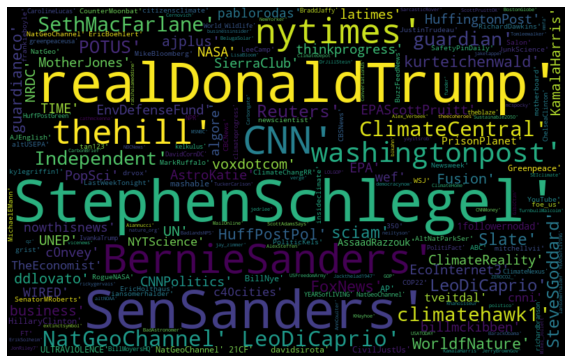

In [28]:
df_mentions = df_with_metadata['mentions'].dropna()
all_words_mentions = ' '.join([text for text in df_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_mentions)

print('Word cloud of top mentions')
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

There is a much wider spread of mentions with DonalTrump topping the list. The mentions which are prominent include : **'realDonaldTrump', 'POTUS', 'SenSanders', 'CNN'** etc. Which also makes it seem as though these tweets were taking during the election time.
One has to be cautious when analyzing mentions as there are two types of main mentions on Twitter :

1) **Where a twitter profile is referred to**

2) **Where a twitter profile Retweets something**

Since a mention occurs every time a tweet is retweeted, it might be worth looking into the mentions of only the retweets if time had allowed.

Let's have a look at character count distribution for these tweets:


#### Character and word count

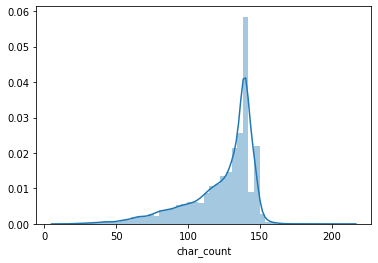

In [29]:
# Display distribution of total characters
sns.distplot(df_with_metadata['char_count'])

We can see from this plot that most of the tweets are using the full amount of characters allowed (140). We will see how these changes in each category. 

### EDA for categories

Let's dig a bit deeper into the tweets in each category to see if we can find out the reason they were classified in this manner as well as seeing if we can identify any similarities.

We start by separating the dataframes to analyze each category and looking at the most common mentions and hashtags.

In [30]:
# Dataframes for each category
df_negative_tweets = df_with_metadata[df['sentiment'] == -1]
df_neutral_tweets = df_with_metadata[df['sentiment'] == 0]
df_positive_tweets = df_with_metadata[df['sentiment'] == 1]
df_news_tweets = df_with_metadata[df['sentiment'] == 2]
df_negative_tweets.head()

,sentiment,message,tweetid,message_token,retweet,hashtags,hashtag_count,mentions,mention_count,char_count,word_count,avg_word_length,stopword_count,cleaned_text
28,-1,Sally Kohn’s latest evidence of climate change...,355491,"[Sally, Kohn, ’, s, latest, evidence, of, clim...",no,NaN,0,[twitchyteam],1,139,21,5.67,8,"[sally, kohn, ’, late, evidence, climate, chan..."
46,-1,@realDonaldTrump Carbon Tax is a Globalist ide...,61141,"[@, realDonaldTrump, Carbon, Tax, is, a, Globa...",no,NaN,0,[realDonaldTrump],1,137,21,5.57,8,"[@realdonaldtrump, carbon, tax, globalist, ide..."
48,-1,RT @SteveSGoddard: We had winds close to 100 M...,719523,"[RT, @, SteveSGoddard, :, We, had, winds, clos...",yes,NaN,0,[SteveSGoddard],1,136,24,4.67,9,"[rt, @stevesgoddard, wind, close, mph, area, a..."
56,-1,@MissLizzyNJ lmao 😂 snowflakes ❄️ complaining ...,911385,"[@, MissLizzyNJ, lmao, 😂, snowflakes, ❄️, comp...",no,NaN,0,[MissLizzyNJ],1,96,14,5.93,2,"[@misslizzynj, lmao, 😂, snowflakes, ❄, ️, comp..."
57,-1,RT @Dawn2334Dawn: This is ONE of Arnold Schwar...,768263,"[RT, @, Dawn2334Dawn, :, This, is, ONE, of, Ar...",yes,NaN,0,[Dawn2334Dawn],1,140,21,5.71,7,"[rt, @dawndawn, arnold, schwarzenegger's, vehi..."


#### Most common mentions
We look at the most common mentions per category.

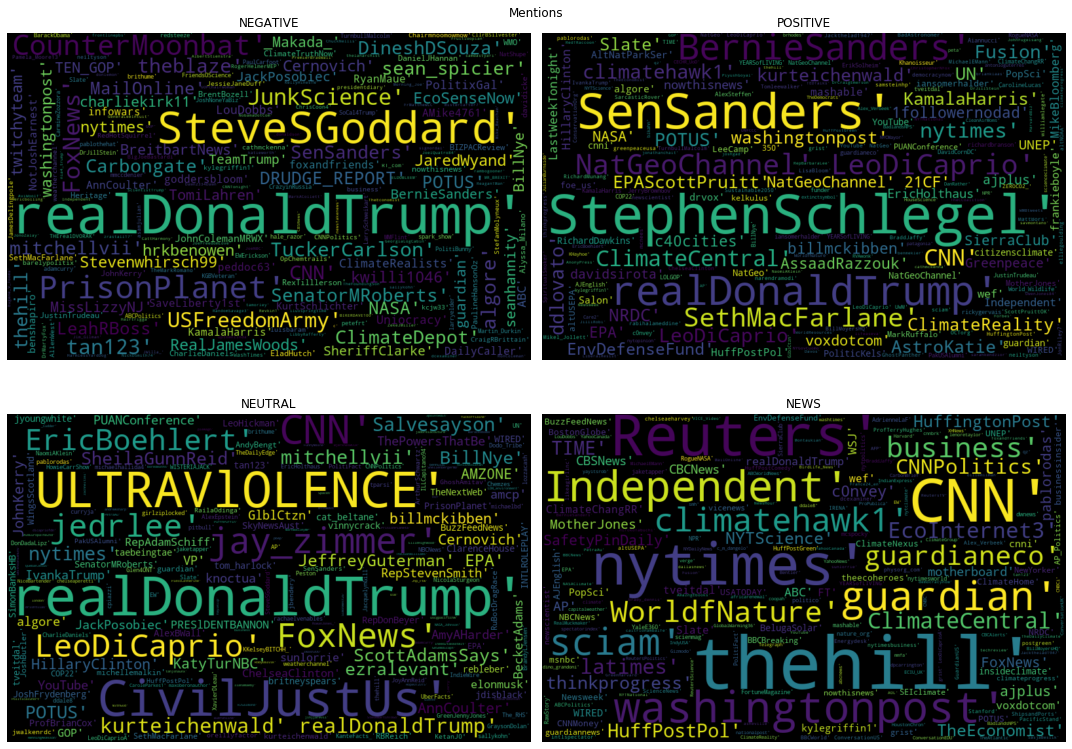

In [31]:
# Negative
df_neg_mentions = df_negative_tweets['mentions'].dropna()
all_words_mentions_neg = ' '.join([text for text in df_neg_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud1 = WordCloud(width=800, height=500, random_state=21, 
                       max_font_size=110).generate(all_words_mentions_neg)

# Neutral
df_neut_mentions = df_neutral_tweets['mentions'].dropna()
all_words_mentions_neut = ' '.join([text for text in df_neut_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud2 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_mentions_neut)

# Positive
df_pos_mentions = df_positive_tweets['mentions'].dropna()
all_words_mentions_pos = ' '.join([text for text in df_pos_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud3 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_mentions_pos)

# News
df_news_mentions = df_news_tweets['mentions'].dropna()
all_words_mentions_news = ' '.join([text for text in df_news_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud4 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_mentions_news)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))
fig.suptitle('Mentions')
axes[0,0].imshow(wordcloud1, interpolation="bilinear")
axes[0,0].axis('off')
axes[0,0].set_title('NEGATIVE')
axes[1,0].imshow(wordcloud2, interpolation="bilinear")
axes[1,0].axis('off')
axes[1,0].set_title('NEUTRAL')
axes[0,1].imshow(wordcloud3, interpolation="bilinear")
axes[0,1].axis('off')
axes[0,1].set_title('POSITIVE')
axes[1,1].imshow(wordcloud4, interpolation="bilinear")
axes[1,1].axis('off')
axes[1,1].set_title('NEWS')
fig.tight_layout()

#### Most common hastags
Now we look at the most common hashtags per category.

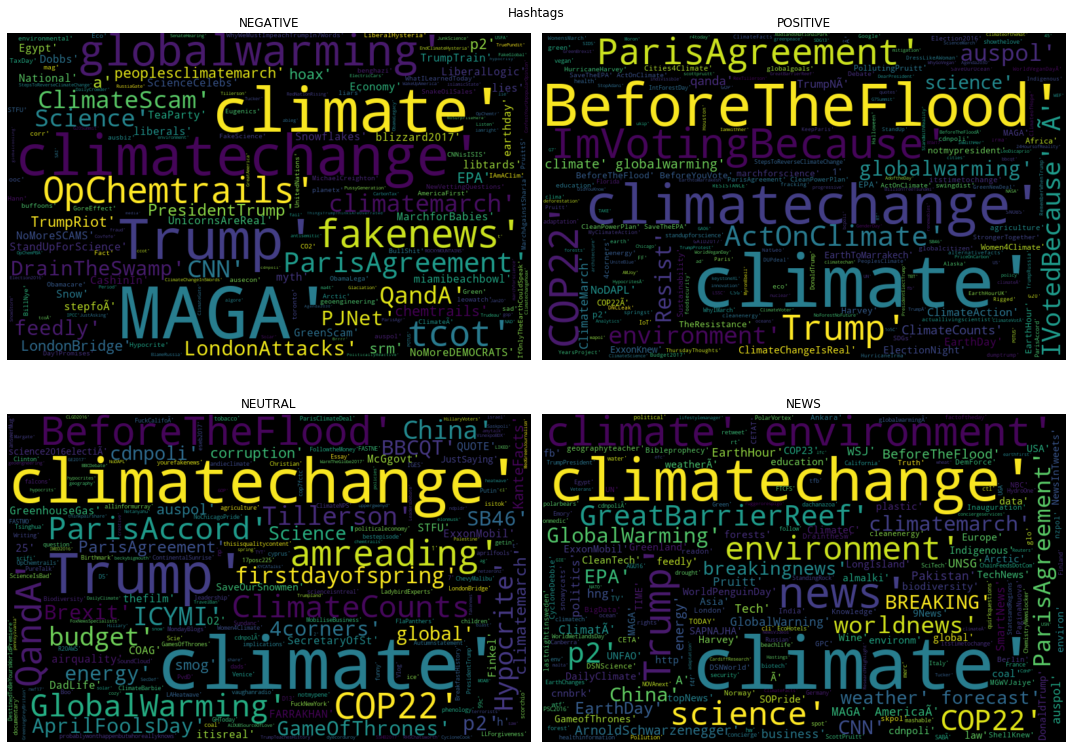

In [32]:
# Negative
df_neg_mentions = df_negative_tweets['hashtags'].dropna()
all_words_mentions_neg = ' '.join([text for text in df_neg_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud1 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_mentions_neg)

# Neutral
df_neut_mentions = df_neutral_tweets['hashtags'].dropna()
all_words_mentions_neut = ' '.join([text for text in df_neut_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud2 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_mentions_neut)

# Positive
df_pos_mentions = df_positive_tweets['hashtags'].dropna()
all_words_mentions_pos = ' '.join([text for text in df_pos_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud3 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_mentions_pos)

# News
df_news_mentions = df_news_tweets['hashtags'].dropna()
all_words_mentions_news = ' '.join([text for text in df_news_mentions.astype(str)])
from wordcloud import WordCloud
wordcloud4 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_mentions_news)

#plot all 4 wordclouds

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))
fig.suptitle('Hashtags')
axes[0,0].imshow(wordcloud1, interpolation="bilinear")
axes[0,0].axis('off')
axes[0,0].set_title('NEGATIVE')
axes[1,0].imshow(wordcloud2, interpolation="bilinear")
axes[1,0].axis('off')
axes[1,0].set_title('NEUTRAL')
axes[0,1].imshow(wordcloud3, interpolation="bilinear")
axes[0,1].axis('off')
axes[0,1].set_title('POSITIVE')
axes[1,1].imshow(wordcloud4, interpolation="bilinear")
axes[1,1].axis('off')
axes[1,1].set_title('NEWS')
fig.tight_layout()


#### Most important words

Let's put together a dataframe of the top words, hashtags and mentions so that we can see what words are influencing each category.

In [33]:
# word frequency function
def word_freq(clean_text_list, top_n):
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [35]:
cl_text_list = df_with_metadata['cleaned_text'].tolist()
wf = word_freq(cl_text_list, 20)
wf

,0,1
0,change,12670
1,climate,12645
2,rt,9720
3,â,4476
4,global,3782
5,…,3565
6,warming,2861
7,¢,2602
8,‚,2256
9,¬,2222


### EDA Summary 
Let's summarise a few key points of what we have found so far:

1) About 60% of these tweets are positive towards climate change - This indicates an imbalanced training dataset.

2) This data seems to be taken from Americans around the time of the 2016 US presidential elections.

3) @realDonaldTrump is the top mentioned account 

4) 'Climatechange', 'climate', and 'Trump' are the three most used hashtags

5) The full character limit of 140 characters was used in the majority of these tweets.

6) Retweets create duplicate data points in the dataset

# 8. Modeling <a name="modeling"></a>

[Return to top](#top) <br><br>


# Preprocessing

In [ ]:
# Remove links

In [ ]:
# Tokenize (experiment with different tokenizers)

In [ ]:
# Convert to lowercase

In [ ]:
# POS tagging (experiment)

In [ ]:
# Perform NER and add your own values (experiment)

In [ ]:
# Stemming (experiment)

In [ ]:
# Lemmatization (experiment)

In [109]:
# Remove punctuation

In [ ]:
# Remove numbers

In [ ]:
# Create custom stopwords list (add 'RT')

In [ ]:
# Remove stopwords

# EDA

In [ ]:
# Most common words for all tweets

In [ ]:
# Most common words for tweets per category

In [ ]:
# Most common bigrams per category

In [ ]:
# Average word count for each tweet per category

In [ ]:
# Average character count for each tweet per category

In [ ]:
# Investigate hashtags

In [ ]:
# Investigate mentions

In [ ]:
# Investigate Retweets

In [ ]:
# Investigate Emoticons

In [ ]:
# Investigate Clustering

In [ ]:
# Revise stopwords list

# Vectorize

In [ ]:
# Import vectorizers

In [ ]:
# Tfidf vectorizer for base model

In [ ]:
# Perform gridsearch or vectorizer parameters

In [ ]:
# Create function to check different vectorizers performance

# Topic Modelling

In [ ]:
# LDA clustering - have to use countvectorizer

In [ ]:
# NNMF - use Tfidf Vectorizer - do this in conjunction with 1vR model

# Balance Data

In [ ]:
# Use upsampling for base model

In [ ]:
# Test different balancing techniques

In [ ]:
# Understand which data needs to be resampled and what it does to the model

# Models

In [ ]:
# Import easy models

In [ ]:
# Fit Models

In [ ]:
# Check best performing for baseline model (use cross validation)

In [ ]:
# Perform grid search for best parameters for best model

In [ ]:
# Investigate more complex modelling techniqes and implement separately

# Model Evaluation

In [ ]:
# Look at model performance (confusion matrix,accuracy,f1score)

In [ ]:
# Figure out what is causing the false positives and false negatives and update model to fix these